In [1]:
import pycrfsuite
import os
from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

from itertools import chain

## Prepare data

In [2]:
def return_file_path(dir_path, file_path):
    return os.path.join(dir_path, file_path)

In [4]:
def convert_x_i(x_i):
    features_dict = defaultdict()
    num_features = len(x_i)

    dd = defaultdict()

    dd['bias'] = 1.0

    for idx in range(num_features):
        pixel_i = "pixel_" + str(idx)
        dd[pixel_i] = x_i[idx]

    return dd


def convert_x(file_path):
    x_arr = []

    with open(file_path, "r") as x_file:
        for x_i_str in x_file:
            x_i_str = x_i_str.strip()
            x_i_str_arr = x_i_str.split()
            x_i = [float(x_ij) for x_ij in x_i_str_arr]

            x_i_features = convert_x_i(x_i)

            x_arr.append(x_i_features)

    return x_arr


def prepare_data(data_dir, mode = "train"):
    file_dir = os.path.join(data_dir, "{}_words".format(mode))
    words_file = return_file_path(data_dir, "{}_words.txt".format(mode))

    X = []
    Y = []

    with open(words_file) as f:
        for line in f:
            line = line.strip()
            i, word = line.split()

            x_i_file_path = return_file_path(file_dir, "text_{}.txt".format(i))
            x_i_arr  = convert_x(x_i_file_path)

            y_i_arr = list(word)

            X.append(x_i_arr)
            Y.append(y_i_arr)

    return X, Y

## Training

In [5]:
def train_model(X, Y, max_iter_count,  model_store = "handwriting-reco-without-transition.crfsuite"):
    trainer = pycrfsuite.Trainer(verbose=False)

    for xseq, yseq in zip(X, Y):
        trainer.append(xseq, yseq)

    trainer.set_params({
        'c1': 1.0,   # coefficient for L1 penalty
        'c2': 1e-3,  # coefficient for L2 penalty
        'max_iterations': max_iter_count,  # stop earlier

        # include transitions that are possible, but not observed
        'feature.possible_transitions': False
    })
    return trainer

In [6]:
data_dir = './data'
X_train, Y_train = prepare_data(data_dir)
trainer = train_model(X_train, Y_train, 300)

In [7]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [8]:
trainer.train("handwriting-reco-without-transition")

In [9]:
history_log = trainer.logparser.iterations[290:300]
for log in history_log:
    print (log)

{'num': 291, 'scores': {}, 'loss': 48616.998369, 'feature_norm': 81.109918, 'error_norm': 190.033007, 'active_features': 3630, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 1.63}
{'num': 292, 'scores': {}, 'loss': 48614.966994, 'feature_norm': 81.169106, 'error_norm': 245.586771, 'active_features': 3630, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 1.629}
{'num': 293, 'scores': {}, 'loss': 48613.472277, 'feature_norm': 81.227089, 'error_norm': 255.462485, 'active_features': 3632, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 1.635}
{'num': 294, 'scores': {}, 'loss': 48610.33438, 'feature_norm': 81.285118, 'error_norm': 213.263277, 'active_features': 3633, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 1.67}
{'num': 295, 'scores': {}, 'loss': 48608.523446, 'feature_norm': 81.340861, 'error_norm': 212.62459, 'active_features': 3634, 'linesearch_trials': 2, 'linesearch_step': 0.5, 'time': 1.63}
{'num': 296, 'scores': {}, 'loss': 48606.094163, 'featu

## Evaluation

In [5]:
def get_preds(X, model_store = "handwriting-reco-without-transition"):
    tagger = pycrfsuite.Tagger()
    tagger.open(model_store)
    Y_pred = [tagger.tag(x) for x in X]

    return Y_pred

def test_model(X_test, Y_test):
    Y_test_pred = get_preds(X_test)

    lb = LabelBinarizer()

    y_test_combined = lb.fit_transform(list(chain.from_iterable(Y_test)))
    y_pred_combined = lb.transform(list(chain.from_iterable(Y_test_pred)))

    print ("Test accuracy : {}".format(accuracy_score(y_test_combined, y_pred_combined)))

In [6]:
data_dir = './data'
X_test, Y_test = prepare_data(data_dir, mode = "test")

In [ ]:
test_model(X_test, Y_test)

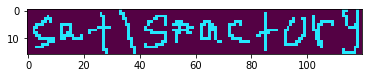

['s', 'a', 't', 'i', 's', 'f', 'a', 'c', 't', 'o', 'r', 'y']


In [12]:
import cv2
import matplotlib.pyplot as plt

idx = 2
test_dir = './data/test_words'
img_name = 'img_' + str(idx) + '.png'   # img file name: img_13480.png
img = cv2.imread(os.path.join(test_dir, img_name))
plt.imshow(img)
plt.show()
print (Y_test[idx])